4. a cGAN (to generate the images as per the expression)

In [1]:
# let's start by importing important libraries


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

# Defining paths and categories
data_dir = 'C:/Users/dhill/VS-Code/dataset'
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to load images from directory
def load_images_from_category(category, data_dir):
    images = []
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(128, 128))  # Adjust target_size as needed
        image = img_to_array(image)
        images.append(image)
    return np.array(images)

# Loading images for each category
data = {}
for category in categories:
    data[category] = load_images_from_category(category, data_dir)

# Normalizing images to [-1, 1]
for category in categories:
    data[category] = (data[category].astype(np.float32) - 127.5) / 127.5

# Example of loading one image
sample_image = data['Happy'][0]  # Adjust category and index as needed
print(f"Shape of sample image: {sample_image.shape}")


Shape of sample image: (128, 128, 3)


Number of images in each category:
Ahegao: 305
Angry: 413
Happy: 740
Neutral: 1027
Sad: 934
Surprise: 334


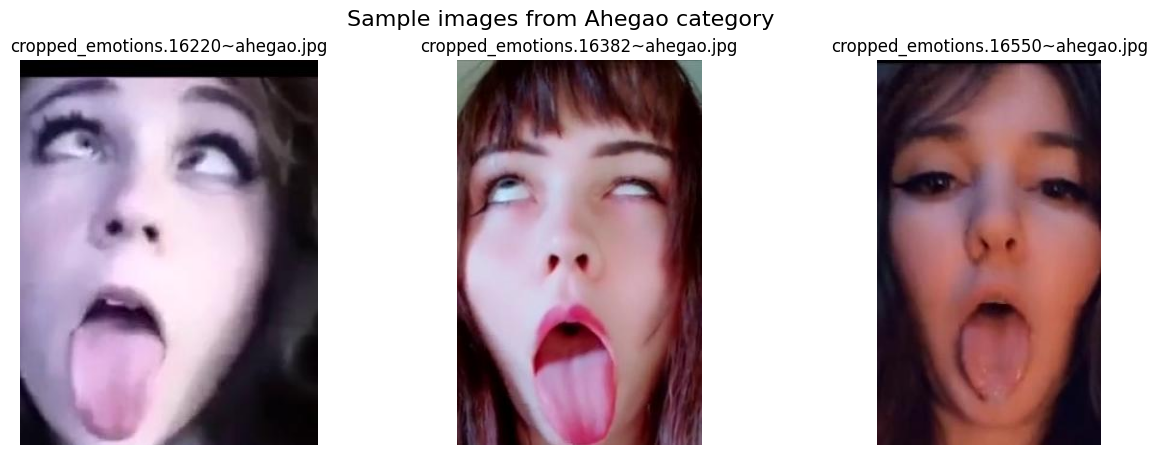

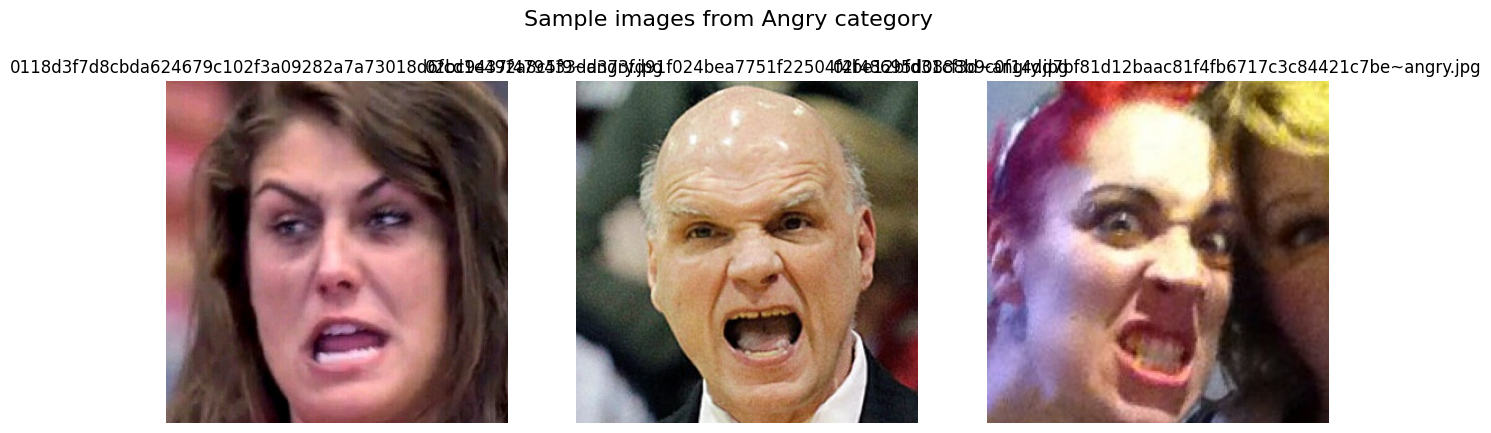

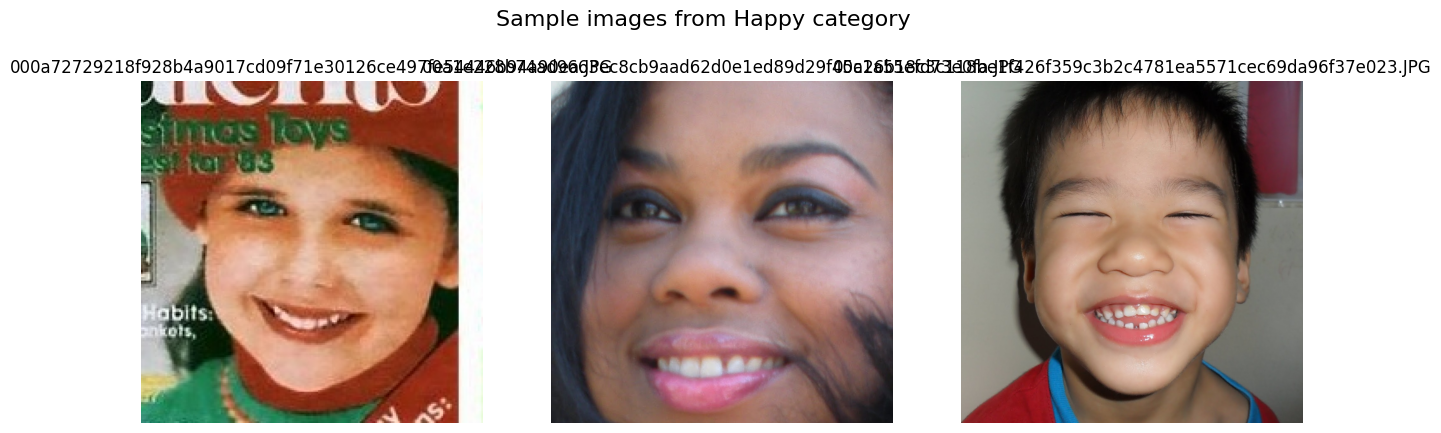

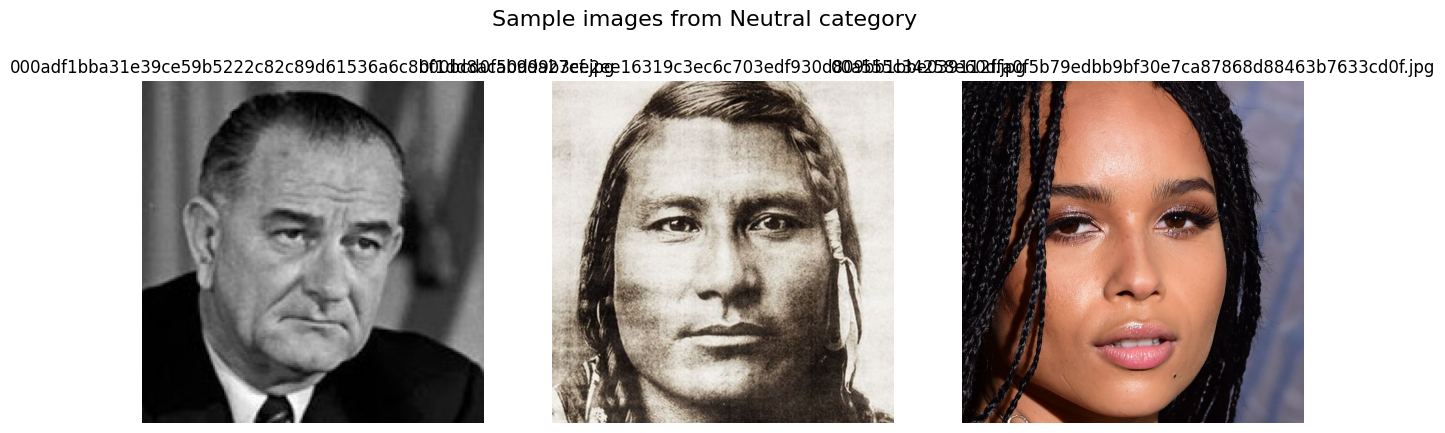

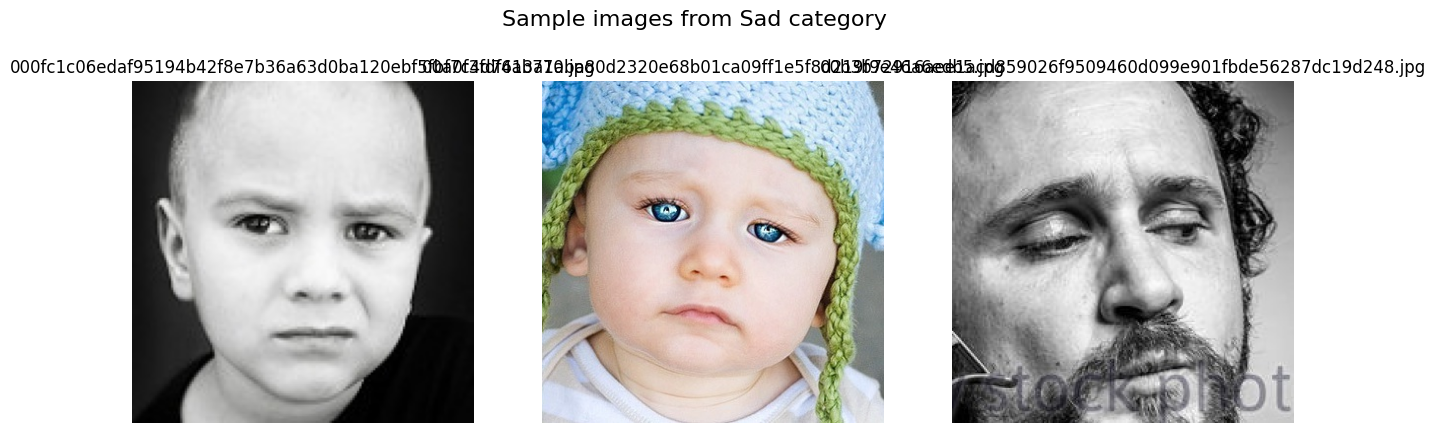

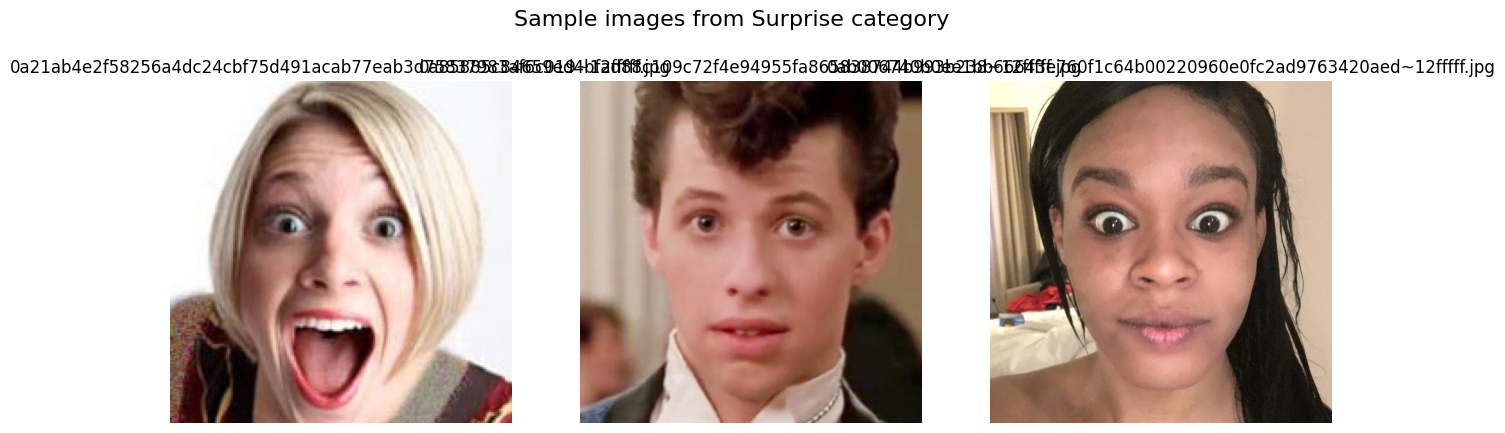

In [2]:


# Function to get the number of images in each category
def get_image_counts(data_dir, categories):
    counts = {}
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

# Function to display sample images from each category
def display_sample_images(data_dir, categories, samples=3):
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        image_files = os.listdir(category_dir)
        
        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Sample images from {category} category', fontsize=16)
        
        for i, image_file in enumerate(image_files[:samples]):
            image_path = os.path.join(category_dir, image_file)
            img = Image.open(image_path)
            plt.subplot(1, samples, i + 1)
            plt.imshow(img)
            plt.title(image_file)
            plt.axis('off')
        
        plt.show()

# Get the image counts for each category
image_counts = get_image_counts(data_dir, categories)
print("Number of images in each category:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

# Display sample images from each category
display_sample_images(data_dir, categories)


In [3]:
# Defining constants
IMG_SHAPE = (128, 128, 3)  # Image shape
NUM_CLASSES = len(categories)  # Number of expression categories
LATENT_DIM = 100  # Dimensionality of the latent space

# Generator function
def build_generator(latent_dim):
    model = Sequential(name="Generator")
    
    # Input layer
    model.add(Dense(16 * 16 * 256, input_dim=latent_dim))
    model.add(Reshape((16, 16, 256)))
    
    # Convolutional layers
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))

    # Output layer
    model.add(Conv2D(3, kernel_size=5, activation='tanh', padding='same'))

    return model

# Discriminator function
def build_discriminator(img_shape):
    model = Sequential(name="Discriminator")
    
    # Convolutional layers
    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    # Output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# Creating instances of generator and discriminator
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator(IMG_SHAPE)

# Compiling discriminator (use binary crossentropy loss)
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Combining generator and discriminator into a single cGAN model
discriminator.trainable = False  # Set discriminator weights as non-trainable
gan_input = Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name="cGAN")

# Compiling cGAN
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Function to generate and save images
def generate_and_save_images(epoch, generator, latent_dim, categories):
    examples_per_category = 1
    random_latent_vectors = np.random.normal(size=(len(categories), latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images 0-1

    for i in range(len(categories)):
        img = generated_images[i]
        img = np.clip(img, 0, 1)
        img = img * 255
        img = img.astype(np.uint8)
        filename = f"generated_{epoch}_expression_{categories[i]}.png"
        imageio.imwrite(filename, img)

# Training loop
def train_gan(generator, discriminator, gan, data, latent_dim, epochs, batch_size, categories):
    for epoch in range(epochs):
        for category in categories:
            real_images = data[category]

            # Adversarial ground truths
            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            # Training the discriminator
            idx = np.random.randint(0, real_images.shape[0], batch_size)
            imgs = real_images[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, valid)

        # Printing progress
        print(f"Epoch {epoch+1}/{epochs}, [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}%], [G loss: {g_loss}]")

        # Generating and save images at certain intervals
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(epoch, generator, latent_dim, categories)

# Set hyperparameters
epochs = 13  # Adjust as needed
batch_size = 32  # Adjust as needed

# Train the cGAN
train_gan(generator, discriminator, gan, data, LATENT_DIM, epochs, batch_size, categories)


c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


c:\Users\dhill\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Epoch 1/13, [D loss: 0.6892068386077881, acc.: 43.29%], [G loss: [array(0.68944234, dtype=float32), array(0.68944234, dtype=float32), array(0.4140625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Epoch 2/13, [D loss: 0.6890503168106079, acc.: 37.98%], [G loss: [array(0.6892011, dtype=float32), array(0.6892011, dtype=float32), array(0.37239584, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Epoch 3/13, [D loss

In [4]:
from tensorflow.keras.models import save_model

save_model(generator, 'generator_model_final.h5')
save_model(discriminator, 'discriminator_model_final.h5')


In [5]:
from tensorflow.keras.models import load_model

# Loading the generator model
generator = load_model('generator_model_final.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

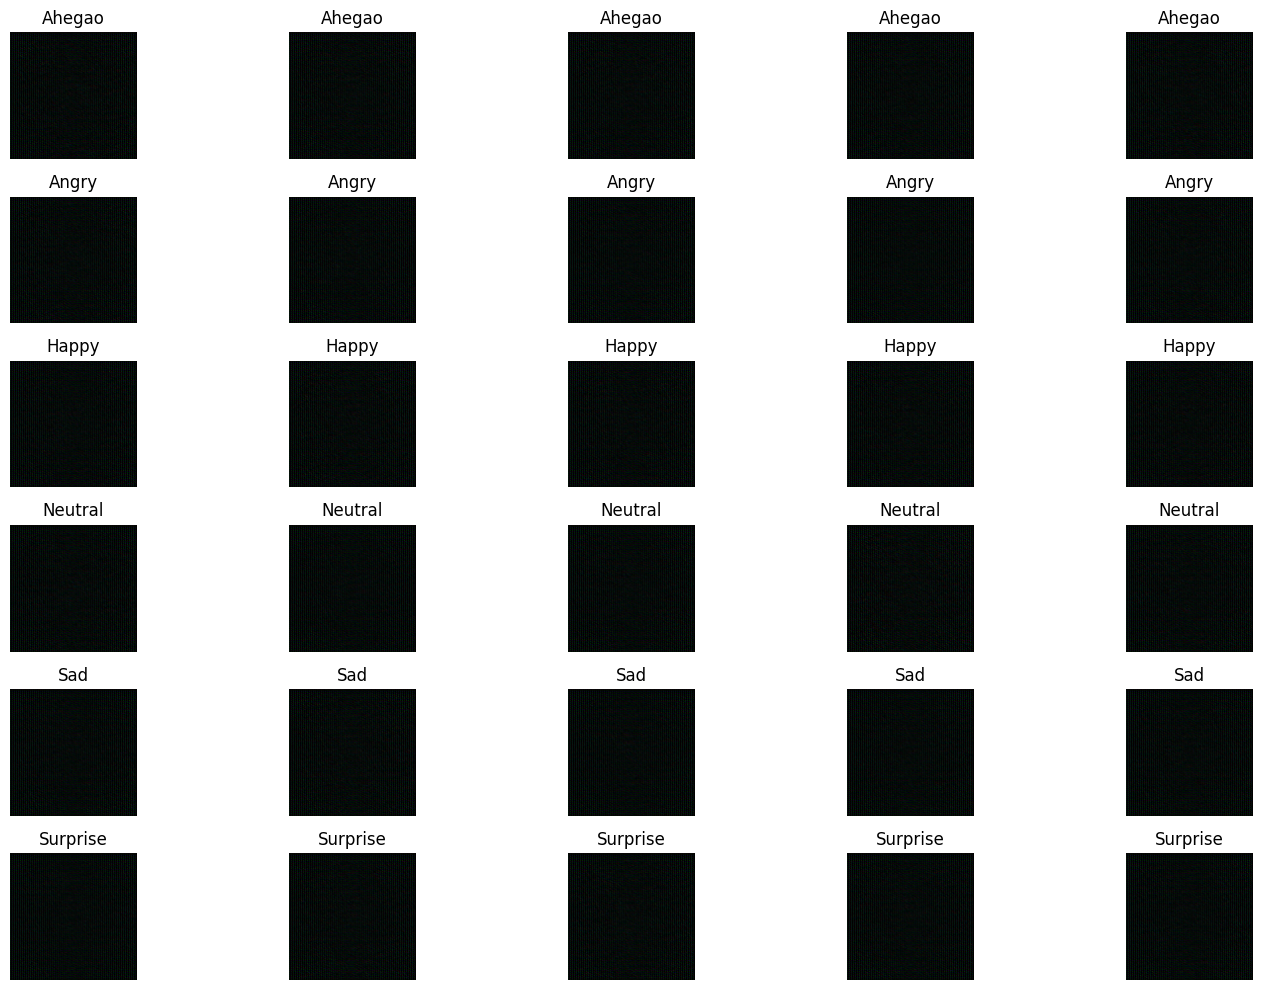

In [6]:
from tensorflow.keras.models import load_model

# Assuming LATENT_DIM is defined and matches your model's latent dimension size
LATENT_DIM = 100  # Example latent dimension size

# Defining categories
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Loading the generator model
generator = load_model('generator_model_final.h5')

# Function to generate images for each expression
def generate_images(generator, latent_dim, categories, num_images=5):
    generated_images = []
    labels = []

    for category in categories:
        for i in range(num_images):
            # Generate random noise
            noise = np.random.normal(0, 1, (1, latent_dim))

            # Generate image
            generated_image = generator.predict(noise)

            # Append generated image and label
            generated_images.append(generated_image[0])
            labels.append(category)

    return generated_images, labels

# Generating images and labels
generated_images, labels = generate_images(generator, LATENT_DIM, categories, num_images=5)

# Displaying images with labels using Matplotlib
plt.figure(figsize=(15, 10))
for i in range(len(generated_images)):
    plt.subplot(len(categories), 5, i + 1)
    plt.imshow(generated_images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.linalg import sqrtm
import os
import glob


# Function to generate images
def generate_images(generator, latent_dim, categories, num_images_per_category=50):
    generated_images = []
    for category in categories:
        for _ in range(num_images_per_category):
            noise = np.random.normal(0, 1, (1, latent_dim))
            generated_image = generator.predict(noise)
            generated_images.append(generated_image)
    return np.array(generated_images)

# Loading InceptionV3 model for IS calculation
inception_model_top = InceptionV3(weights='imagenet', include_top=True, input_shape=(299, 299, 3))

# Preprocessing images for InceptionV3
def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        img = image.array_to_img(img[0], scale=False)
        img = img.resize((299, 299))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        preprocessed_images.append(img)
    return np.vstack(preprocessed_images)

# Function to calculate Inception Score (IS)
def calculate_inception_score(images, inception_model, splits=10):
    preds = inception_model.predict(images)
    preds = np.exp(preds) / np.sum(np.exp(preds), axis=1, keepdims=True)  # Convert logits to probabilities
    scores = []
    for i in range(splits):
        part = preds[i * (preds.shape[0] // splits): (i + 1) * (preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# Function to load and preprocess real images from multiple subfolders
def load_and_preprocess_real_images(dataset_dir):
    real_images = []
    categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']  # Adjust based on your folder names

    for category in categories:
        folder_path = os.path.join(dataset_dir, category)
        if not os.path.exists(folder_path):
            print(f"Folder '{category}' not found.")
            continue
        
        image_paths = glob.glob(os.path.join(folder_path, '*.jpg'))  # Assuming images are JPEGs
        for image_path in image_paths:
            img = image.load_img(image_path, target_size=(299, 299))
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            real_images.append(img)

    if real_images:
        return np.vstack(real_images)
    else:
        return None

# Assuming your dataset directory is 'C:/Users/dhill/VS-Code/dataset/'
dataset_dir = 'C:/Users/dhill/VS-Code/dataset/'

# Generate and preprocess generated images
generated_images = generate_images(generator, LATENT_DIM, categories, num_images_per_category=100)
preprocessed_generated_images = preprocess_images(generated_images)

# Load and preprocess real images
preprocessed_real_images = load_and_preprocess_real_images(dataset_dir)

# Check shapes for debugging
if preprocessed_real_images is not None:
    print(f'Preprocessed real images shape: {preprocessed_real_images.shape}')
else:
    print('Failed to load or preprocess real images.')

# Calculate Inception Score
is_mean, is_std = calculate_inception_score(preprocessed_generated_images, inception_model_top)
print(f'Inception Score: {is_mean}, Std: {is_std}')

# Load InceptionV3 model for FID calculation (without top layer)
inception_model_avgpool = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Function to calculate FID
def calculate_fid(real_images, generated_images, inception_model):
    real_activations = inception_model.predict(real_images, batch_size=32)
    generated_activations = inception_model.predict(generated_images, batch_size=32)
    
    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_activations, axis=0), np.cov(generated_activations, rowvar=False)
    
    ssd = np.sum((mu_real - mu_generated)**2)
    covmean = sqrtm(sigma_real.dot(sigma_generated))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssd + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid

# Calculate FID
fid_score = calculate_fid(preprocessed_real_images, preprocessed_generated_images, inception_model_avgpool)
print(f'FID: {fid_score}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━